In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import datetime
%load_ext tensorboard

In [2]:
#check if GPU exists and if so limit its memory allocation to run multiple models or conserve resources
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num of GPUs available: ', len(physical_devices))  

try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print('Memory growth controlled') 
except:
  # if GPU can't be used or CUDA error
  print('Device error')

Num of GPUs available:  1
Memory growth controlled


In [35]:
#load data using Keras image generator, data imbalance can also be addressed using it by using augmentation
def load_data(paths, dim, class_names, batch_size, augmentation=False):
    print('check paths: ', paths)
    if augmentation==False:
        datagen = ImageDataGenerator(rescale=1./255) #normalize images )
        valid_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)
    if augmentation == True:
        datagen = ImageDataGenerator(
        rescale=1./255, #normalize images
        rotation_range = 30, #randomly rotate images in the range (0, 180)
        width_shift_range = 0.4, 
        height_shift_range = 0.3,
        horizontal_flip = True,
        vertical_flip = True,
        zoom_range = 0.1,
        shear_range=0.1
    )
        valid_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)
    train = datagen.flow_from_directory(paths[0], target_size = dim, color_mode='grayscale', classes = class_names, batch_size = batch_size, shuffle=True)
    valid = valid_datagen.flow_from_directory(paths[1], target_size = dim, color_mode='grayscale',  classes = class_names, batch_size = batch_size, shuffle=True)
    test = test_datagen.flow_from_directory(paths[2], target_size = dim,  color_mode='grayscale', classes = class_names, batch_size = batch_size, shuffle=False)
    # testset shuffle false as confusion matrix requires unshuffled labels
    return train, valid, test

#### Here we can use sklearn for train, test split but using the keras magedatagenerator object, we can load a batch of images at a time into memory

In [27]:
DATADIR = os.path.join(os.getcwd() , 'dataset', 'data')
paths = [DATADIR+'\\train', DATADIR+'\\valid', DATADIR+'\\test']

train_batches, valid_batches, test_batches = load_data(paths=paths, dim=(224, 224), 
                                                         class_names=['cats', 'dogs'], batch_size=32)

check paths:  ['C:\\Users\\hamza\\Projects\\python_projects\\InnSol\\dataset\\data\\train', 'C:\\Users\\hamza\\Projects\\python_projects\\InnSol\\dataset\\data\\valid', 'C:\\Users\\hamza\\Projects\\python_projects\\InnSol\\dataset\\data\\test']
Found 5000 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [28]:
train_imgs, train_labels = next(train_batches)

In [29]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize= (20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

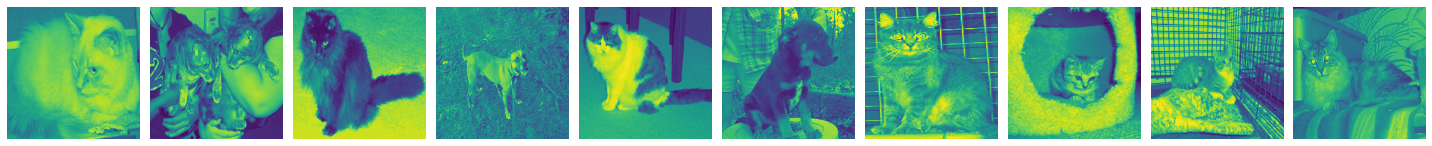

[[1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]]


In [30]:
plotImages(train_imgs) #grayscaled and color distorted
print(train_labels.T)

In [31]:
class_labels = valid_batches.class_indices
print('training set size is\n', 'cats:', len(os.listdir(paths[0] + '/cats')), 'dogs:', len(os.listdir(paths[0] + '/dogs')))
print('no validation set exists')
print('test set size', len(os.listdir(paths[2] + '/cats')),len(os.listdir(paths[2] + '/dogs')))
print('class labels are:', class_labels)
print('tensor shape', next(train_batches)[0].shape)

training set size is
 cats: 4000 dogs: 1001
no validation set exists
test set size 1000 1000
class labels are: {'cats': 0, 'dogs': 1}
tensor shape (32, 224, 224, 1)


#### I can either apply augmentation and increase the dataset imbalance or add new data. Since the goal is to classify cats and dogs and this dataset has been taken from kaggle(also checked CIFAR10) i will use the complete data from kaggle.

In [ ]:
#use kaggle_data_splitter to create a train, valid, test directory structure with automatic data handling
#module exists inside this directory. make sure your dataset is in dataset/kaggle and the structure is 
#is same as the original dir

#i have created this function
from kaggle_data_splitter import kaggle_data_splitter
kaggle_data_splitter('dataset/kaggle')

In [32]:
DATADIR = os.path.join(os.getcwd(), 'dataset', 'kaggle')
paths = [os.path.join(DATADIR + '\\train'), os.path.join(DATADIR+ '\\valid'), os.path.join(DATADIR+ '\\test')]

In [36]:
train_batches, valid_batches, test_batches = load_data(paths=paths, dim=(224, 224), 
                                                         class_names=['cats', 'dogs'], batch_size=32)

check paths:  ['C:\\Users\\hamza\\Projects\\python_projects\\InnSol\\dataset\\kaggle\\train', 'C:\\Users\\hamza\\Projects\\python_projects\\InnSol\\dataset\\kaggle\\valid', 'C:\\Users\\hamza\\Projects\\python_projects\\InnSol\\dataset\\kaggle\\test']
Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Now the dataset is balanced

In [37]:
def create_model():
    model = Sequential([
        Conv2D(filters = 16, kernel_size = (4, 4), activation = 'relu', padding = 'same', input_shape=(224, 224, 1)),
        MaxPool2D(pool_size = (5, 5), strides=2),
        Conv2D(filters = 32, kernel_size = (5, 5), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (5, 5), strides=2),
        Conv2D(filters = 64, kernel_size = (5, 5), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (5, 5), strides=2),
        Conv2D(filters = 128, kernel_size = (5, 5), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (5, 5), strides=2),
        Flatten(),
        Dense(units=512, activation='relu'),
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        Dense(units=64, activation='relu'),
        Dense(units=2, activation='softmax')
    ])
    return model

In [38]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       2

In [42]:
tb_name = 'fit'
checkpoint_path = "checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# this will save the model weights on every 10 steps, it will also save tensorboard data for visualization
def create_callbacks(cp_path, tb_folder):
    path_ = os.getcwd()
    # Create a callback that saves the model's weights every 5 epochs
    cp_callback = ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        period=10)

    call_tensorboard = TensorBoard(log_dir=path_+'/logs/{}'.format(tb_folder))

    return [call_tensorboard, cp_callback]

In [43]:
def train_model():
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    model.save_weights(checkpoint_path.format(epoch=0))
    model.fit(x=train_batches, validation_data=valid_batches, epochs=60, verbose=1, callbacks = create_callbacks(checkpoint_path, tb_name))

In [44]:
train_model()

Epoch 1/60
  1/313 [..............................] - ETA: 0s - loss: 0.6868 - accuracy: 0.5312WARNING:tensorflow:From C:\Users\hamza\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
313/313 [==============================] - 24s 77ms/step - loss: 0.6872 - accuracy: 0.5412 - val_loss: 0.6726 - val_accuracy: 0.5845
Epoch 2/60
313/313 [==============================] - 16s 50ms/step - loss: 0.6595 - accuracy: 0.6124 - val_loss: 0.6275 - val_accuracy: 0.6545
Epoch 3/60
313/313 [==============================] - 16s 50ms/step - loss: 0.6245 - accuracy: 0.6556 - val_loss: 0.6069 - val_accuracy: 0.6600
Epoch 4/60
313/313 [==============================] - 16s 50ms/step - loss: 0.5939 - accuracy: 0.6892 - val_loss: 0.5724 - val_accuracy: 0.7045
Epoch 5/60
313/313 [======================

313/313 [==============================] - 16s 50ms/step - loss: 0.2392 - accuracy: 0.9040 - val_loss: 0.3382 - val_accuracy: 0.8590
Epoch 49/60
313/313 [==============================] - 16s 50ms/step - loss: 0.2339 - accuracy: 0.9087 - val_loss: 0.3428 - val_accuracy: 0.8520
Epoch 50/60
312/313 [============================>.] - ETA: 0s - loss: 0.2239 - accuracy: 0.9131
Epoch 00050: saving model to checkpoint\cp-0050.ckpt
313/313 [==============================] - 16s 52ms/step - loss: 0.2237 - accuracy: 0.9132 - val_loss: 0.3371 - val_accuracy: 0.8655
Epoch 51/60
313/313 [==============================] - 16s 50ms/step - loss: 0.2253 - accuracy: 0.9116 - val_loss: 0.3514 - val_accuracy: 0.8550
Epoch 52/60
313/313 [==============================] - 16s 50ms/step - loss: 0.2187 - accuracy: 0.9141 - val_loss: 0.3467 - val_accuracy: 0.8615
Epoch 53/60
313/313 [==============================] - 16s 50ms/step - loss: 0.2078 - accuracy: 0.9215 - val_loss: 0.3486 - val_accuracy: 0.8575
Epoc

In [3]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 15788), started 0:01:46 ago. (Use '!kill 15788' to kill it.)

In [59]:
#this function requires an import to plot the confusion matrix, it evaluates the model
#generates a classifacation report using sklearn

def test_model():
    from plot_confusion_matrix import plot_confusion_matrix
    print('test set loaded: ' , test_batches.classes.shape)
    plotImages(test_imgs)
    predictions = model.predict(x = test_batches, verbose=0)
    print('predictions acquired with tensor shape: ', predictions.shape)
    print('plotting confusion matrix and generating classification report')
    cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=1)) 
    plot_confusion_matrix(cm, names, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues)
    print('Classification Report')
    print(classification_report(test_batches.classes, np.argmax(predictions, axis=1)
                                , target_names=names))

test set loaded:  (2000,)


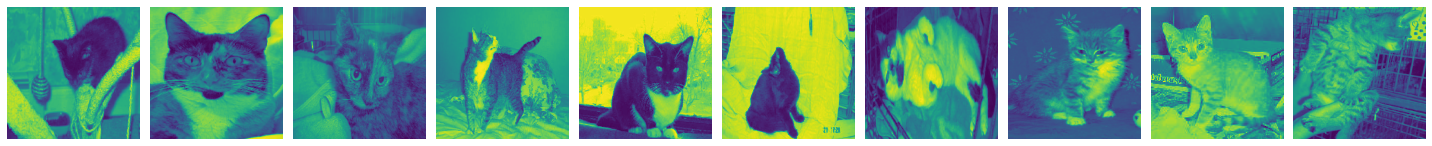

predictions acquired with tensor shape:  (2000, 2)
plotting confusion matrix and generating classification report
Confusion matrix, without normalization
[[819 181]
 [ 95 905]]


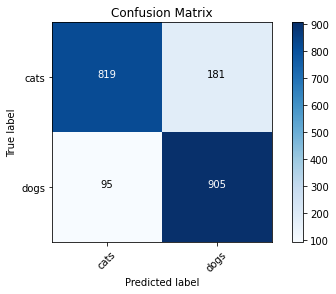

Classification Report
              precision    recall  f1-score   support

        cats       0.90      0.82      0.86      1000
        dogs       0.83      0.91      0.87      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



In [60]:
test_model()

In [66]:
#save model to be deployed for web applications and microservices
def save_model():
    print('model saved in "model" directory')
    model.save("models")

In [67]:
save_model()

model saved in "model" directory
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models\assets
